In [1]:
#!/usr/bin/python
# updated DBR 11/2023 #

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

sns.set_style("ticks")


In [2]:
df=pd.read_csv('data/clean/IPDA-dbrclean.csv') #import data

#note I had previously taken out zeros by hand, just deleting (to make nan), could do the 1/Tcells thing?

#get geometric means and std across the replicates, eventually fit to ln(mean)

df['int']=10**np.nanmean(np.log10(df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7']]),axis=1)
df['int_sd']=10**np.nanstd(np.log10(df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7']]),axis=1)
df['lint']=np.log(df['int'])

df['tot']=10**np.nanmean(np.log10(df[['Tot1','Tot2', 'Tot3', 'Tot4', 'Tot5', 'Tot6', 'Tot7']]),axis=1)
df['tot_sd']=10**np.nanstd(np.log10(df[['Tot1','Tot2', 'Tot3', 'Tot4', 'Tot5', 'Tot6', 'Tot7']]),axis=1)
df['ltot']=np.log(df['tot'])

#some janky reformatting
for i in range(1,8):
    df['def'+str(i)]=df['Tot'+str(i)]-df['I'+str(i)]

df['def']=10**np.nanmean(np.log10(df[['def1', 'def2', 'def3', 'def4', 'def5', 'def6', 'def7']]),axis=1)
df['def_sd']=10**np.nanstd(np.log10(df[['def1', 'def2', 'def3', 'def4', 'def5', 'def6', 'def7']]),axis=1)
df['ldef']=np.log(df['def'])

ppts=df['pid'].unique()

In [3]:
#just use these 4 to match rest of paper
ppt4=[22, 548,  583, 746, 1211]

dfmem=pd.DataFrame()
for p in ppt4:
    dfmem=dfmem._append(df[df['pid']==p]) #note new method _append to not look like lists?

In [4]:
dfmem.columns

Index(['pid', 'ARTmo', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'Tot1',
       'Tot2', 'Tot3', 'Tot4', 'Tot5', 'Tot6', 'Tot7', 'int', 'int_sd', 'lint',
       'tot', 'tot_sd', 'ltot', 'def1', 'def2', 'def3', 'def4', 'def5', 'def6',
       'def7', 'def', 'def_sd', 'ldef'],
      dtype='object')

[-0.01741887013237504, -0.028276793680105744, -0.006560946584644336]
[ 39.79288985  24.51293412 105.64743541]
[-0.007199477807057772, -0.017663487211590126, 0.0032645315974745796]
[  96.27742444   39.24180838 -212.32668757]


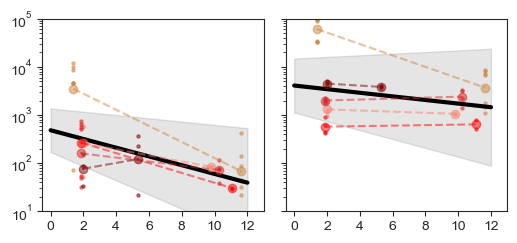

In [18]:
#loop through intact/defective and model

czl=['salmon','peru','red','tab:red','maroon',]
maxyr=12
simt=np.linspace(0,maxyr*12,100)

#cz=['magenta','indigo']
cz=['black','black']
titz=['Intact','Defective']
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(6,2.5))

meml=[]
for ii, dd in enumerate(['int','def']):
            
    #run MEM
    md = smf.mixedlm('l'+dd+' ~ ARTmo', dfmem, groups=dfmem['pid'])
    mdf = md.fit()
    mem_results=[mdf.params[1],mdf.conf_int().iloc[1,0],mdf.conf_int().iloc[1,1],
                 mdf.params[0],mdf.conf_int().iloc[0,0],mdf.conf_int().iloc[0,1]]
    
    print(mem_results[:3])
    print(-np.log(2)/mem_results[:3])
    
    meml.append([dd]+mem_results[:3]) #for output

    for ip,p in enumerate(ppt4):
        tdf=dfmem[(dfmem['pid']==p)]
        #axs[ii].plot(tdf['ARTmo']/12,tdf[dd],color=czl[ip],ls='--',marker='o',alpha=0.5)#cz_list[pind])
        axs[ii].errorbar(tdf['ARTmo']/12,tdf[dd],2*tdf[dd+'_sd'],color=czl[ip],ls='--',marker='o',alpha=0.5)#cz_list[pind])

        #for error bars, should be on log scale, so like log(mean)+2*log(sd)
                
    axs[ii].plot(simt/12,np.exp(mem_results[3]+mem_results[0]*simt),color=cz[ii],lw=3)
    axs[ii].fill_between(simt/12,np.exp(mem_results[4]+mem_results[1]*simt),np.exp(mem_results[5]+mem_results[2]*simt),color=cz[ii],alpha=0.1)
    
    hll=[]
    titzi = titz[ii]+'\n'
    for im in range(3):
        hll=str(int(-np.log(2)/mem_results[im]))
        titzi+=hll+', '
    
    #axs[ii].set_title(titzi)
    #axs[ii].set_xlabel('Time (years on ART)')

    
#or raw replicate data
for ip,p in enumerate(ppt4):
    tdf=dfmem[(dfmem['pid']==p)]
    for irep in range(1,8):
        axs[0].scatter(tdf['ARTmo']/12,tdf['I'+str(irep)],marker='o',s=5,c=czl[ip],alpha=0.5)
        axs[1].scatter(tdf['ARTmo']/12,tdf['def'+str(irep)],marker='o',s=5,c=czl[ip],alpha=0.5)

#axs[0].set_ylabel('HIV DNA per million CD4 cells')

plt.semilogy()
axs[ii].set_xticks(range(0,25,2))
axs[ii].set_ylim([10,1e5])
axs[ii].set_yticks([10,100,1000,1e4,1e5])
plt.xlim([-0.5,maxyr+1])
plt.subplots_adjust(wspace=0.1)
#plt.legend()
#plt.tight_layout()    
plt.savefig('figures/IPDAout.svg')


In [22]:
dfout = pd.DataFrame(meml,columns=['DNAtype','mean','loCI','upCI'])

dfout['se']=(dfout['upCI']-dfout['loCI'])/(2*1.96)

dfout.to_csv('data/clean/IPDArates.csv')